In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette(palette="flare")
from datetime import datetime
import ast

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler

#Feature Selection
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV

#Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix

#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [2]:
train_file = pd.read_csv(r'data/train.csv')
df_train = pd.DataFrame(train_file)

test_file = pd.read_csv(r'data/test.csv')
df_test = pd.DataFrame(test_file)

Initial Data Exploration revealed:
* We have 9100 guest records, none of them duplicated (though some have repeated names);
* Date_Birth has 105 missing values;
* Deposit_Kept and Time_Room_Service have strongly right-skewed distributions;

# Stage 1: Feature Engineering & Feature Selection

### 1.1. Basic Preprocessing & Feature Engineering

Performing basic feature engineering for two demographic attributes - Age (from Birth_Date) and Gender (from Name's preffixes) and an overall score, which is likely important because a customer's standard may be very high (the promotors) or very low (the detractors) 

In [3]:
def preprocessing_and_feature_engineering(dataset):

    dataset.set_index('Guest_ID', inplace = True)

    dataset['Date_Birth'] = pd.to_datetime(dataset['Date_Birth'])

    #Computing Age variable
    dataset.insert(0, 'Age', pd.Timestamp('now').year - pd.DatetimeIndex(dataset['Date_Birth']).year)

    #Computing Gender variable
    dataset.insert(1, 'Gender_IsMale', dataset['Name'].map(lambda x: x.split(" ")[0]) \
                                                      .replace({'Mr.': 1,
                                                                'Mrs.': 0,
                                                                'Miss': 0}))

    #Computing Overall Average Score
    score_columns = ['Room',
                     'Check-in/Check-out',
                     'F&B',
                     'Location',
                     'Wifi',
                     'Entertainment',
                     'Gym',
                     'Spa',
                     'Staff',
                     'Pool',
                     'Baggage_Handling',
                     'Reception',
                     'Cleanliness',
                     'Online_Booking']
    dataset['Average_Score'] = dataset.loc[:, score_columns] \
                                      .mean(axis = 1)
    
    #Normalizing highly skewed variables
    dataset['Deposit_Kept'] = stats.yeojohnson(dataset['Deposit_Kept'])[0]
    dataset['Time_Room_Service'] = stats.yeojohnson(dataset['Time_Room_Service'])[0]

    #Dropping no longer relevant features
    dataset = dataset.drop(columns = ['Date_Birth', 'Name'])
    
    #Handling categorical variables 
    dataset = dataset.join(pd.get_dummies(dataset.select_dtypes(exclude = np.number),
                                          drop_first = True)) \
                     .drop(columns = ['Type', 'Flight_Class'])
    
    return dataset

#Passing the fuction to both df_train and df_test 
df_train = df_train.pipe(preprocessing_and_feature_engineering)
df_test = df_test.pipe(preprocessing_and_feature_engineering)

#Splitting the dataframe in explanatory variables and target
X = df_train.drop(columns = ['Repeater'])
y = df_train['Repeater']

#Scaling, for the algorithms which may need it
X_scaled = MinMaxScaler().fit_transform(X)
# Convert the array to a pandas dataframe
X_scaled = pd.DataFrame(X_scaled, columns = X.columns).set_index(X.index)

### 1.2. Feature Selection

In [4]:
# Creating a df copy for feature selection evaluations
fs_df = df_train.copy()

#Temporarily imputting age with a constant so LassoCV can evaluate it
fs_df['Age'].fillna(30, inplace = True)
fs_df['Age'] = fs_df['Age'].astype(int)

X_fs = fs_df.drop(columns = ['Repeater'])
X_fs_scaled = MinMaxScaler().fit_transform(X_fs)
X_fs_scaled = pd.DataFrame(X_fs_scaled, columns = X.columns).set_index(X.index)
y_fs = fs_df['Repeater']

#### 1.2.1. Correlations

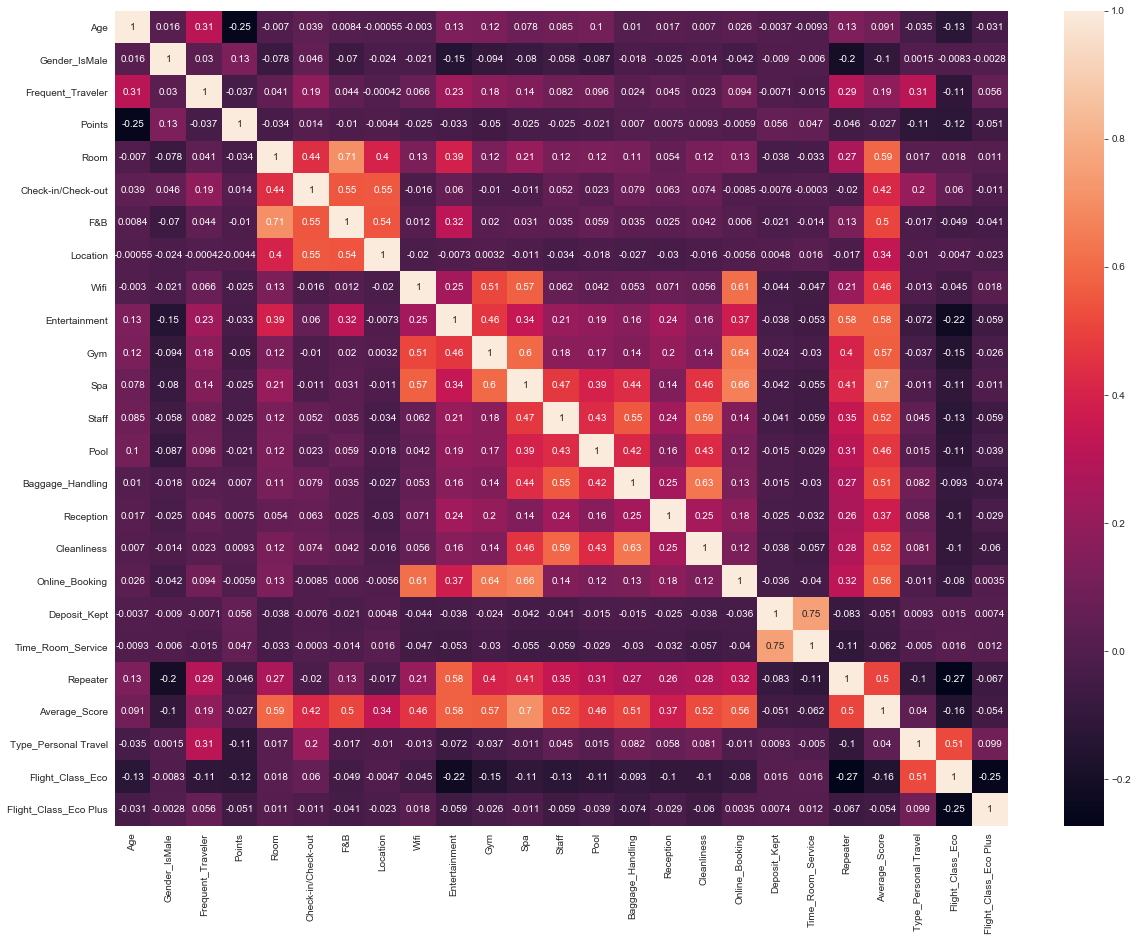

In [5]:
def correlation_heatmap(dataframe, method):
    fig = plt.figure(figsize = (20,15))
    dataframe_corr = dataframe.corr(method = method)
    sns.heatmap(dataframe_corr, annot = True)

correlation_heatmap(fs_df, 'spearman')

Entertainment has the highest correlation with the target variable (around 0.57), followed by Average_Score (0.50) and Spa (0.41);

In [6]:
dataframe_corr = fs_df.corr(method = 'spearman')
dataframe_corr['Repeater'].sort_values(ascending = False)

Repeater                 1.000000
Entertainment            0.575519
Average_Score            0.503554
Spa                      0.413458
Gym                      0.399269
Staff                    0.346795
Online_Booking           0.315510
Pool                     0.310460
Frequent_Traveler        0.294774
Cleanliness              0.278272
Baggage_Handling         0.270705
Room                     0.265573
Reception                0.264980
Wifi                     0.212471
Age                      0.132636
F&B                      0.129043
Location                -0.017333
Check-in/Check-out      -0.020170
Points                  -0.046313
Flight_Class_Eco Plus   -0.067316
Deposit_Kept            -0.082506
Type_Personal Travel    -0.103605
Time_Room_Service       -0.108715
Gender_IsMale           -0.200961
Flight_Class_Eco        -0.272926
Name: Repeater, dtype: float64

Perhaps we could exclude **Location**, **Check-in/Check-out**, **Points**, and **Flight_Class_Eco Plus**

#### 1.2.1. Chi-Square Tests for independency

In [7]:
def TestIndependence(X, y, var, alpha):        
    dfObserved = pd.crosstab(y, X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns = dfObserved.columns, index = dfObserved.index)
    if p >= alpha:
        print("{0} is not important".format(var))
    
for var in df_train.columns:
    TestIndependence(fs_df[var], y_fs, var, 0.05)

Apparently all variables are important, according to Chi-Square tests

#### 1.2.2. Lasso CV (Embedded Method)

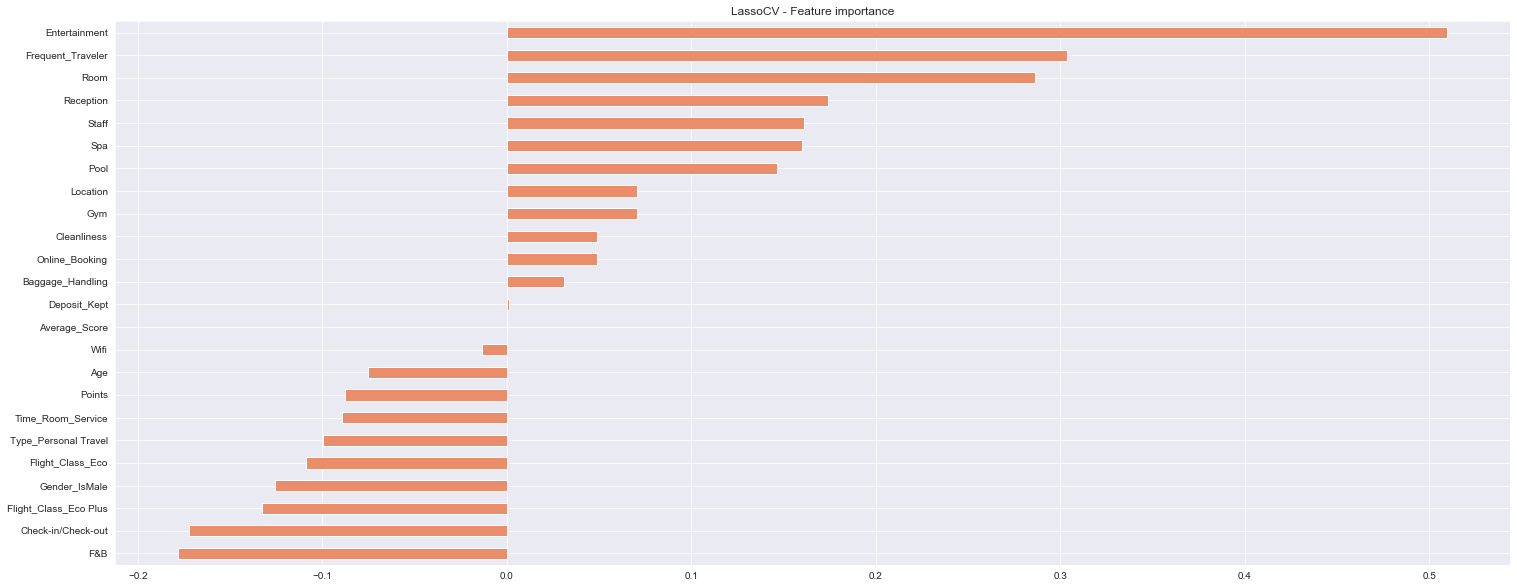

In [8]:
#LassoCV instance
reg = LassoCV()
reg.fit(X_fs_scaled, y_fs)

#Plotting the variable importance according to LassoCV
coef = pd.Series(reg.coef_, index = X_fs_scaled.columns)
importance = coef.sort_values()

plt.figure(figsize = (25, 10))
importance.plot(kind = "barh")

plt.title("LassoCV - Feature importance")
plt.show()

LassoCV says we should:
* Definitely remove:
    * **Deposit_Kept**
    * **Average_Score**
* Maybe remove:
    * **Wifi**
    * **Bagage_Handling**

#### 1.2.3. RFE (w/ Logistic Regression)

In [9]:
X_fs_train, X_fs_val, y_fs_train, y_fs_val = train_test_split(X_fs_scaled, y_fs, test_size = 0.3, random_state = 0, stratify = y, shuffle = True)

nr_features = np.arange(1, len(X_fs_scaled.columns))
high_score = 0

#Variable to store the optimum features
nof = 0           
score_list = []
for n in range(len(nr_features)):
    model = LogisticRegression()
    rfe = RFE(model, nr_features[n])
    X_train_rfe = rfe.fit_transform(X_fs_train, y_fs_train)
    X_val_rfe = rfe.transform(X_fs_val)
    model.fit(X_train_rfe, y_fs_train)
    
    score = model.score(X_val_rfe, y_fs_val)
    score_list.append(score)
    
    if(score > high_score):
        high_score = score
        nof = nr_features[n]
        
print("Optimum Number of Features: %d" %nof)

Optimum Number of Features: 19


In [10]:
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = nof)
X_rfe = rfe.fit_transform(X = X_fs_train, y = y_fs_train)

In [11]:
RFE_outcome = pd.DataFrame({'variable': X_fs_train.columns, 'RFE': rfe.support_})
RFE_outcome[~RFE_outcome['RFE']]

,variable,RFE
7,Location,False
8,Wifi,False
14,Baggage_Handling,False
17,Online_Booking,False
18,Deposit_Kept,False


RFE says we should remove:
* **Deposit_Kept** (again)
* **Wifi** (again)
* **Bagage_Handling** (again)
* **Location**
* **Online_Booking**

**In Conclusion**, we could build four scenarios:
1. We discard nothing (perhaps in tree-based algorithms it's our best choice since they select the most important features for themselves, but let's see)
2. We discard Deposit_Kept, Wifi, Location & Bagage_Handling (the ones that appeared more than once)
3. We discard Deposit_Kept, Wifi, Location, Bagage_Handling, Online_Booking, Check-in/Check-out, Points, and Flight_Class_Eco Plus (the ones that appeared at least once)
4. We discard only Deposit_Kept and Wifi. This was the original attempt and seemed to somehow deliver the best results, so I will try some models with this scenario.

After some tests, let's stick with settings 2 for the model trials and settings 4 for the final models.

In [12]:
def feature_selection_setting2(dataset):

    irrelevant_variables = ['Deposit_Kept', 'Wifi', 'Location', 'Baggage_Handling'] 
    dataset = dataset.drop(columns = irrelevant_variables)
    return dataset

def feature_selection_setting4(dataset):

    irrelevant_variables = ['Deposit_Kept', 'Wifi'] 
    dataset = dataset.drop(columns = irrelevant_variables)
    return dataset

In [13]:
def handling_age(dataset):
    
    #Imputting Age with the mean age
    dataset['Age'].fillna(round(np.mean(df_train['Age'])), inplace = True)
    dataset['Age'] = dataset['Age'].astype(int)
    return dataset

# Stage 2: Model Trials

In [14]:
def grid_search(model, hyperparameters, X_df, y):

    grid_search = GridSearchCV(estimator = model,
                               param_grid = hyperparameters,
                               n_jobs = -1,
                               cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 10),
                               scoring = 'f1',
                               verbose = 1,
                               error_score = 'raise')

    grid_result = grid_search.fit(X_df, y)
    return grid_result

def grid_search_results(grid_result, details):

    # Results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_) + '\n')

    if details == 1:
        #More info
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
           print("%f (%f) with: %r" % (mean, stdev, param))

In [15]:
def randomized_search(model, hyperparameters, X_df, y, n_iter):

    randm = RandomizedSearchCV(estimator = model,
                               param_distributions = hyperparameters,
                               n_jobs = -1,
                               cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 10),
                               n_iter = n_iter,
                               scoring = 'f1',
                               verbose = 2,
                               error_score = 'raise')

    randm_result = randm.fit(X_df, y)
    return randm_result

def randomized_search_results(randm_result, details):

    # Results
    print("Best: %f using %s" % (randm_result.best_score_, randm_result.best_params_) + '\n')

    if details == 1:
        #More info
        means = randm_result.cv_results_['mean_test_score']
        stds = randm_result.cv_results_['std_test_score']
        params = randm_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
           print("%f (%f) with: %r" % (mean, stdev, param))

We're trying all the following models with Settings 2, which seems to be the most balanced one.

In [16]:
#Setting 2
df_set2 = df_train.copy() \
                  .pipe(feature_selection_setting2) \
                  .pipe(handling_age)
X_set2 = df_set2.drop(columns = ['Repeater'])
X_set2_scaled = MinMaxScaler().fit_transform(X_set2)
X_set2_scaled = pd.DataFrame(X_set2_scaled, columns = X_set2.columns).set_index(X_set2.index)

### 2.1. K-Nearest Neighbors
Best: **0.915246**

In [ ]:
knn = KNeighborsClassifier()

# When weights = distance, an even n_neighbors makes sense
n_neighbors = list(range(1, 31))
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan']
knn_parameters = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)

grid_result = grid_search(knn, knn_parameters, X_set2_scaled, y)
grid_search_results(grid_result, 0)

### 2.2. Logistic Regression
Best: **0.840551**

In [ ]:
logr = LogisticRegression()

solvers = ['newton-cg', 'sag', 'saga', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]

logr_parameters = dict(solver = solvers, penalty = penalty, C = c_values)

grid_result = grid_search(logr, logr_parameters, X_set2, y)
grid_search_results(grid_result, 0)

### 2.3. AdaBoost
Best: **0.897659** 

In [ ]:
ada = AdaBoostClassifier()

ada_parameters = {'algorithm': ['SAMME', 'SAMME.R'],
                  'n_estimators': sp_randInt(100, 200),
                  'learning_rate': sp_randFloat(0.0, 0.2)}

randm_result = randomized_search(ada, ada_parameters, X_set1, y, 10)
randomized_search_results(randm_result, 0)

### 2.4 Support Vector Machines
Best: **0.925556**

In [ ]:
svc = SVC()

svc_parameters = {'kernel': ['poly', 'rbf', 'sigmoid'],
                  'C': [50, 10, 1.0, 0.1, 0.01],
                  'gamma' : ['scale']}

randm_result = randomized_search(svc, svc_parameters, X_set2_scaled, y, 10)
randomized_search_results(randm_result, 0)

### 2.5. Bagged Decision Trees
Best: **0.936280**

In [ ]:
bagc = BaggingClassifier()

bagc_parameters = {'n_estimators': sp_randInt(10, 1000)}

randm_result = randomized_search(bagc, bagc_parameters, X_set2, y, 10)
randomized_search_results(randm_result, 0)

### 2.6. Random Forests
Best: **0.938704**

In [ ]:
rfc = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
rfc_parameters = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

randm_result = randomized_search(rfc, rfc_parameters, X_set2, y, 10)
randomized_search_results(randm_result, 0)

From now on, we will focus our efforts on these two models: **Gradient Boosting** and **Histogram-Based Gradient Boosting**. This is because previous attempts with them yielded scores around 95%, considerably higher than all previous tried models (we could also push further for the Random Forests if we had more time, since its results are actually closer to the gradient boostings).

# Stage 3: Optimization - Gradient Boosting and Histogram-Based Gradient Boosting 

### 1.1 Model Set Up

In [17]:
#Setting 4
df_HistGradient_setting4 = df_train.pipe(feature_selection_setting4)
df_GradBoost_setting4 = df_HistGradient_setting4.pipe(handling_age)

X_HistGradient_setting4 = df_HistGradient_setting4.drop(columns = ['Repeater'])
y_HistGradient_setting4 = df_HistGradient_setting4['Repeater']

X_GradBoost_setting4 = df_GradBoost_setting4.drop(columns = ['Repeater'])
y_GradBoost_setting4 = df_GradBoost_setting4['Repeater']

In [18]:
#Creating a dataframe for storing the results
#highest_scores = pd.DataFrame(columns = ['Model', 'Setting', 'Avg_F1', 'Std_F1', 'Min_F1', 'Max_F1', 'BestParams'])

#Uploading the dataframe from the stored csv - to save the records even if the notebook is restarted
highest_scores = pd.read_csv('HighestScores.csv')

In [19]:
def reproduce_best_params(model, model_description, model_run, X, y, setting):
    
    model_bestparam = model
    model_bestparam.set_params(**model_run.best_params_)

    n_scores = cross_val_score(model_bestparam,
                               X,
                               y,
                               scoring = 'f1',
                               cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 10),
                               n_jobs = -1,
                               error_score = 'raise')

    print('Accuracy: %.6f (%.6f)' % (np.mean(n_scores), np.std(n_scores)))

    #Append result to the scores' dataframe
    new_row = {'Model': model_description,
               'Setting': setting,
               'Avg_F1': np.mean(n_scores),
               'Std_F1': np.std(n_scores),
               'Min_F1': np.min(n_scores),
               'Max_F1': np.max(n_scores),
               'BestParams': model_run.best_params_,
               'Kaggle_Score': 0.00,
               'Comments': ''}
    
    return new_row

## 1.2. Histogram Based Gradient Boosting

In [20]:
#parameters to tune
hgbc_parameters = {'max_iter': sp_randInt(1000, 1200),
                  'learning_rate': sp_randFloat(0.11, 0.04),
                  'max_depth': sp_randInt(10, 11),
                  'max_leaf_nodes': sp_randInt(30, 40),
                  'l2_regularization': sp_randFloat(1.51, 0.09)}

### Setting 4

In [ ]:
model = HistGradientBoostingClassifier()
model_description = 'Histogram Gradient'
setting = 4
X = X_HistGradient_setting4
y = y_HistGradient_setting4

nr_of_trials = 1   #In case this code is to be run, i am lowering the number of trials to 1 so it won't take forever to run - Normally I would use nr_of_trials = 4
for i in range(nr_of_trials):
    randm_result = randomized_search(model, hgbc_parameters, X, y, 2)          #Also lowering the number of candidates to 2 so it won't take forever to run - Normally I would use 10 candidates per run
    randomized_search_results(randm_result, 1)

    new_score = reproduce_best_params(model, model_description, randm_result, X, y, setting)
    highest_scores = highest_scores.append(new_score, ignore_index = True)

## 3.3. Gradient Boosting
Best: **0.952063**

In [ ]:
#parameters to tune
gbc_parameters = {'loss': ['deviance', 'exponential'],
                  'n_estimators': sp_randInt(100, 700),     #"Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance."
                  'learning_rate': sp_randFloat(0.05, 0.1),
                  'max_depth': sp_randInt(3, 15),
                  'max_leaf_nodes': sp_randInt(8, 32),
                  'subsample': sp_randFloat(0.85, 0.1)}   #"If smaller than 1.0 this results in Stochastic Gradient Boosting"

### Setting 4

In [ ]:
model = GradientBoostingClassifier()
model_description = 'Gradient Boosting'
setting = 4
X = X_GradBoost_setting4
y = y_GradBoost_setting4

nr_of_trials = 2
for i in range(nr_of_trials):

    randm_result = randomized_search(model, gbc_parameters, X, y, 10)
    randomized_search_results(randm_result, 1)

    new_score = reproduce_best_params(model, model_description, randm_result, X, y, setting)
    highest_scores = highest_scores.append(new_score, ignore_index = True)

### Downloading a specific model to try it on Kaggle

In [21]:
def download_model(model, model_description, X, y, highest_scores_row, setting):
    
    #Computing the model
    model_bestparam = model
    try:
       model_bestparam.set_params(**ast.literal_eval(highest_scores['BestParams'][highest_scores_row]))
    except:
       model_bestparam.set_params(**highest_scores['BestParams'][highest_scores_row])

    n_scores = cross_val_score(model_bestparam,
                               X,
                               y,
                               scoring = 'f1',
                               cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 10),
                               n_jobs = -1,
                               error_score = 'raise')

    print('Accuracy: %.6f (%.6f)' % (np.mean(n_scores), np.std(n_scores)))
    
    #Downloading the file
    if model_description == 'Histogram Gradient':
        if setting == 4:
            df_test_model = df_test.copy().pipe(feature_selection_setting4)
        else:
            df_test_model = df_test.copy()
    else:
        if setting == 2:
            df_test_model = df_test.copy().pipe(handling_age).pipe(feature_selection_setting2)
        if setting == 4:
            df_test_model = df_test.copy().pipe(handling_age).pipe(feature_selection_setting4)
        else:
            df_test_model = df_test.copy().pipe(handling_age)
    
    pred = model_bestparam.fit(X, y)

    test_predict = pred.predict(df_test_model).astype(str)

    test = pd.DataFrame({'Guest_ID': df_test_model.index, 'Repeater': test_predict})
    csv_name = model_description.strip() + '_' + datetime.today().strftime('%Y%m%d_%HH%M') + '.csv'
    test.to_csv(csv_name,
                sep = ',',
                encoding = 'utf-8',
                index = False)

In [22]:
# Downloading the final model
download_model(HistGradientBoostingClassifier(), 'Histogram Gradient', X_HistGradient_setting4, y_HistGradient_setting4, highest_scores_row = 15, setting = 4)

Accuracy: 0.949850 (0.005430)


# HALL OF FAME

In [23]:
highest_scores.to_csv('HighestScores.csv',
                      sep = ',',
                      encoding = 'utf-8',
                      index = False)

In [24]:
highest_scores[highest_scores['Kaggle_Score'] != 0].sort_values(by = 'Kaggle_Score', ascending = False)

,Model,Setting,Avg_F1,Std_F1,Min_F1,Max_F1,BestParams,Kaggle_Score,Comments
0,Histogram Gradient,1,0.948974,0.006200,0.934394,0.958376,"{'l2_regularization': 1.5973574522901122, 'lea...",0.95299,Using Old Settings 1: Removing Deposit_Kept & ...
12,Histogram Gradient,4,0.949893,0.006667,0.935091,0.963415,"{'l2_regularization': 1.5973574522901122, 'lea...",0.95299,"Remake of highest score, with settings 4"
15,Histogram Gradient,4,0.949850,0.005430,0.940120,0.962437,"{'l2_regularization': 1.516657157511436, 'lear...",0.95213,"Lowest Std, Highest Minimum"
20,Histogram Gradient,4,0.949687,0.005838,0.938939,0.961382,"{'l2_regularization': 1.52425959666235, 'learn...",0.95128,NaN
23,Histogram Gradient,4,0.949810,0.005939,0.932933,0.960245,"{'l2_regularization': 1.5663155576208947, 'lea...",0.95128,NaN
13,Histogram Gradient,4,0.950016,0.006039,0.938322,0.961460,"{'l2_regularization': 1.5795969600011515, 'lea...",0.95042,NaN
19,Histogram Gradient,4,0.949830,0.006565,0.936937,0.963415,"{'l2_regularization': 1.5522261766124772, 'lea...",0.95042,NaN
24,Histogram Gradient,4,0.950564,0.005742,0.938939,0.959350,"{'l2_regularization': 1.594248838285813, 'lear...",0.94957,NaN
7,Histogram Gradient,1,0.949398,0.006258,0.933333,0.959016,"{'l2_regularization': 1.5459909232896605, 'lea...",0.94444,Same parameters as the highest score but with ...
9,Gradient Boosting,1,0.952063,0.006348,0.939734,0.962739,"{'learning_rate': 0.1219044033333748, 'loss': ...",0.94358,NaN


Though model 12 is the one yielding the highest score on Kaggle test set (30%), model number 15 has a lower standard deviation of F1 scores among the k-fold candidates, a higher minimum F1 score and almost the same maximum F1 Score. Therefore, for stability, I felt more comfortable using it for the unknown 70%.

## RESULTS
Public Leaderboard (30% test data): F1-Score: 0.95299 - 1st Place   
Private Leaderboard (70% test data): F1-Score: 0.94322 - 3rd Place (tied w/ 2nd)